# DSCI 531 Lab 4 - Exploratory data analysis

In [1]:
# Load packages

import pandas as pd
import altair as alt
import geopandas as gpd
import json
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
import shapely.wkt
import pandas_profiling

# Need to enable this to allow work with larger datasets (https://altair-viz.github.io/user_guide/faq.html)
alt.data_transformers.enable('json')

# source: https://automating-gis-processes.github.io/2017/lessons/L3/point-in-polygon.html

DataTransformerRegistry.enable('json')

In [2]:
url = 'https://data.cityofnewyork.us/api/views/vfnx-vebw/rows.csv'

squirrel_data = pd.read_csv(url, usecols = ['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color', 'Location', 'Kuks', 'Quaas', 'Moans', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Approaches', 'Indifferent', 'Runs from', 'Lat/Long'])
# source (data): https://catalog.data.gov/dataset/2018-central-park-squirrel-census-hectare-data

In [3]:
# Replace NaN with "Unknown"

squirrel_data = squirrel_data.fillna(value = "Unknown")

In [4]:
# Convert lat/long column of squirrel data from string to point
squirrel_data["Lat/Long"] = squirrel_data["Lat/Long"].apply(shapely.wkt.loads)

In [5]:
# Load data needed to map data on park map
geojson_filepath = 'central_park_geo.geojson'

def open_geojson(path):
    """
    Opens a geojson file at "path" filepath
    """
    with open(path) as json_data:
        d = json.load(json_data)
    return d

def get_geopandas_df(path):
    """
    Creates geopandas dataframe from geeojson file 
    at "path" filepath
    """
    open_json = open_geojson(path)
    gdf = gpd.GeoDataFrame.from_features((open_json))
    return gdf

# Create geopandas dataframe from Central Park geoJson file
gdf = get_geopandas_df(geojson_filepath)



# source (code): https://medium.com/dataexplorations/creating-choropleth-maps-in-altair-eeb7085779a1
# source (map data): https://data.cityofnewyork.us/City-Government/Parks-Zones/rjaj-zgq7

In [6]:
# Map 'sitename' from mapping data to location of each squirrel observation
# in 'squirrel_data'
squirrel_data["sitename"] = "not set"

def map_park_site(point):
    """
    Matches point location of observation in squirrel_data to polygon
    in gdf that it lies within. Returns "sitename" of polygon.
    
    Parameters
    ----------
    point
        shapely.point object
    
    Returns
    -------
    string
        sitename value of polygon that point lies within
        
    Examples
    --------
    map_park_site(Point((73, 43)))
    > "Great Lawn"
    -------------
    """
    for poly in gdf["geometry"]:
        if point.within(poly):
            i = list(gdf['sitename'].loc[gdf['geometry'] == poly])
            val = i[0]
            return val

# Map sitename to polygons
squirrel_data['sitename'] = squirrel_data['Lat/Long'].apply(map_park_site)

In [10]:
squirrel_data.columns = [col.replace(' ','_') for col in list(squirrel_data.columns)]

In [11]:
# Prepare data to explore squirrel activity by time of day AND sitename
# Group total squirrel count by shift and site
squirrel_group_shift = (squirrel_data[['sitename','Unique_Squirrel_ID', 'Shift']]
                        .groupby(['sitename','Shift'])
                        .count()
                        .reset_index())
squirrel_shift_am = squirrel_group_shift.query('Shift == "AM"')
squirrel_shift_pm = squirrel_group_shift.query('Shift == "PM"')
# Merge basemap data with grouped squirrel data
squirrel_shift_diff = pd.merge(squirrel_shift_am, squirrel_shift_pm, on = 'sitename')
# Calculate change in squirrel count in afternoon vs. morning
squirrel_shift_diff['Shift_difference'] = squirrel_shift_diff['Unique_Squirrel_ID_y']-squirrel_shift_diff['Unique_Squirrel_ID_x']
# Name columns
squirrel_shift_diff.columns = ['sitename', 
                               'Shift_AM', 
                               'AM Squirrel Count', 
                               'Shift_PM', 
                               'PM Squirrel Count', 
                               'Count_difference']
squirrel_shift_diff = squirrel_shift_diff[['sitename','AM Squirrel Count', 'PM Squirrel Count', 'Count_difference']]

In [12]:
# Prepare squirrel data to graph squirrel counts by park area
squirrel_group_count = squirrel_data[['sitename','Unique_Squirrel_ID']].groupby('sitename').count().reset_index()

# Merge base map data with squirrel data
squirrel_geo_count = pd.merge(gdf, squirrel_group_count, on = 'sitename')

# Add column with Count differences (AM vs. PM)
squirrel_geo_count = pd.merge(squirrel_geo_count, squirrel_shift_diff, on = 'sitename')

# Account for multiple "Central Park West" values
squirrel_geo_count.at[6, 'sitename'] = "Central Park West (Zone 1)"
squirrel_geo_count.at[7, 'sitename'] = "Central Park West (Zone 2)"
squirrel_geo_count.at[8, 'sitename'] = "Central Park West (Zone 3)"
squirrel_geo_count.at[9, 'sitename'] = "Central Park West (Zone 4)"
squirrel_geo_count = squirrel_geo_count.sort_values('Unique_Squirrel_ID')

In [13]:
# Add shortened sitenames for plots

sitename_short_dict = {'Bendheim Plgd' : 'Bendheim Plgd',
'Pat Hoffman Friedman Plgd' : 'P.H.F. Plgd',
'110th St & Lenox Ave Plgd' : '110th St. Plgd',
'Heckscher Plgd' : 'Heckscher Plgd',
'Conservatory Garden' : 'Cons. Garden',
'Northwest Corner' : 'Northwest Corner',
'Reservoir (Southeast)' : 'Reservoir SE',
'Strawberry Fields' : 'Strawberry Fields',
"Frawleys' Run" : "Frawleys' Run",
'The Great Hill' : 'The Great Hill',
"Nutter's Battery & Fort Clinton Site" : "Nutter's Battery",
'The Metropolitan Museum Of Art' : 'The Met',
'Wollman Rink' : 'Wollman Rink',
'79th St Yard And Summit Rock' : 'Summit Rock',
'Pilgrim Hill & Conservatory Water' : 'Pilgrim Hill',
'Wien Walk And Arsenal' : 'Wien Walk',
'Reservoir (Northeast)' : 'Reservior NE', 
'Belvdre. Cstl., Turtle Pond, Shkspr Grdn' : 'Turtle Pond Area',
'Dairy, Chess & Checkers House, Carousel' : 'Carousel Area',
'East Meadow' : 'E Meadow',
'North Of The Arsenal' : 'N of the Arsenal',
'Cedar Hill' : 'Cedar Hill',
'Conservatory Gardens West Landscape' : 'Cons. Gardens W.',
'Hallett Nature Sanctuary And Pond' : 'Hallett Nat. Sanc.',
'Loch Ravine' : 'Loch Ravine',
'Wallach Walk And East Green' : 'Wallach Walk',
'Reservoir (Northwest)' : 'Reservoir NW',
'North Meadow Recreation Center' : 'N Meadow Rec. Ctr.',
'Ross Pinetum' : 'Ross Pinetum',
"Great Lawn And Cleopatra's Needle" : 'Great Lawn',
'Central Park South' : 'Central Park S.',
'Blockhouse One' : 'Blockhouse One',
'Sheep Meadow' : 'Sheep Meadow',
'The Mall And Rumsey Playfield' : 'The Mall',
'North Meadow' : 'N Meadow',
'The Pool' : 'The Pool',
'Bethesda Terrace' : 'Bethesda Terrace',
'Heckscher Ballfields & Playground' : 'Hecksher Ballfields',
'Central Park West (Zone 1)' : 'Central Park W (Z-1)',
'Central Park West (Zone 3)' : 'Central Park W (Z-2)',
'Central Park West (Zone 2)' : 'Central Park W (Z-3)',
'Central Park West (Zone 4)' : 'Central Park W (Z-4)',
'The Ramble' : 'The Ramble'}

squirrel_geo_count['sitename_short'] = squirrel_geo_count['sitename'].replace(sitename_short_dict)

In [14]:
# Convert geopandas dataframe to format
# plottable in Altair
alt_json_count = json.loads(squirrel_geo_count.to_json())
alt_base_layer_data_count = alt.Data(values = alt_json_count['features'])

# source (code): https://medium.com/dataexplorations/creating-choropleth-maps-in-altair-eeb7085779a1

In [15]:
################# TOTAL SQUIRREL COUNT AM vs. PM

# Prepare data to explore squirrel behavior and activity by time of day (shift -- AM vs. PM)
# Group total squirrel count and behaviors by shift
squirrel_count_shift = (squirrel_data[['Shift',
                                       'Unique_Squirrel_ID', 
                                       ]]
                        .groupby('Shift')
                        .count()
                        .reset_index())
squirrel_count_shift

Shift  Unique_Squirrel_ID
0    AM                1347
1    PM                1676

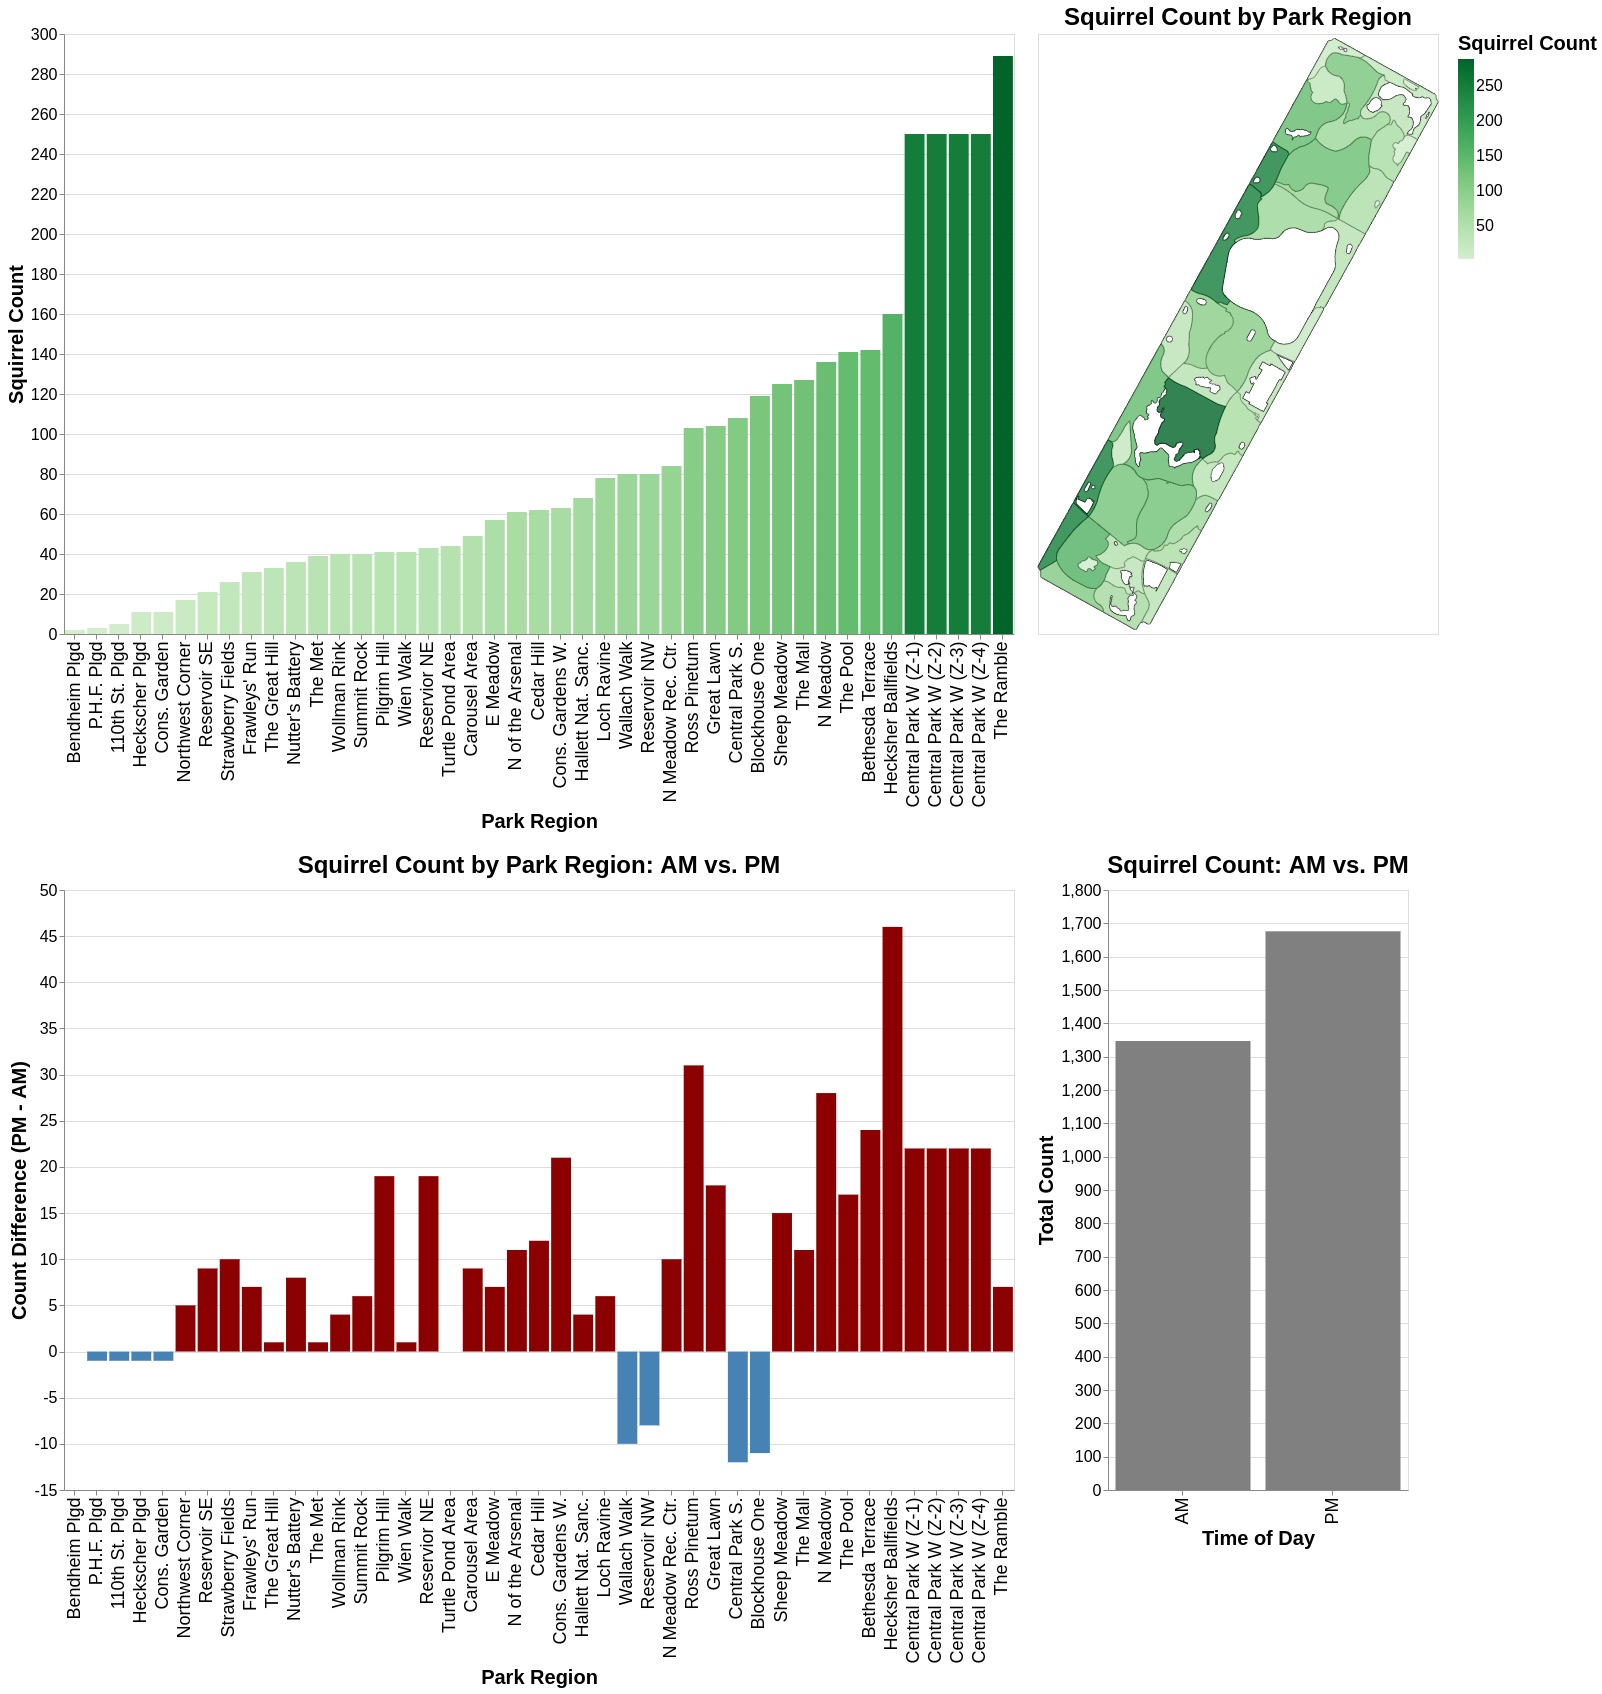

In [16]:
##################################
# Plot Squirrel count by park area
##################################

# Plot choropleth
def plot_count(selection):
    # Plot of squirrel count
    base_map = alt.Chart(alt_base_layer_data_count).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=400,
        height=600
    )

    # Add Choropleth Layer
    choropleth = (alt.Chart(alt_base_layer_data_count, 
                            title = "Squirrel Count by Park Region")
    .mark_geoshape()
    .add_selection(selection)
    .encode(
    # SELECTION SINGLE CONDITIONS -- Color is grey if not selected
        color = alt.condition(selection, 
                              'properties.Unique_Squirrel_ID:Q', 
                              alt.value('grey'),
            title = 'Squirrel Count',
            scale=alt.Scale(scheme='greens'),
            legend = alt.Legend(labelFontSize = 16, 
                                titleFontSize = 20, 
                                tickCount = 5)),
        opacity=alt.condition(selection, 
                              alt.value(0.8), 
                              alt.value(0.1)),
        tooltip = [alt.Tooltip('properties.sitename:N', 
                               title="Park Region"), 
               alt.Tooltip('properties.Unique_Squirrel_ID:Q', 
                           title="Squirrel Count")]
    ))
    
    return(base_map + choropleth)

# Sort data by squirrel count to display sites in ascending order
sort_order = list(squirrel_geo_count['sitename_short'])

# Plot bar chart of counts
def plot_bar(selection):
    count_bar = (alt.Chart(alt_base_layer_data_count)
    .mark_bar()
    .add_selection(selection)
    .encode(
        x = alt.X('properties.sitename_short:N', 
                  title = "Park Region", 
                  axis = alt.Axis(labelFontSize = 18,
                                  titleFontSize = 20), 
                  sort = sort_order),
        y = alt.Y('properties.Unique_Squirrel_ID:Q', 
                  title = "Squirrel Count", 
                  axis = alt.Axis(labelFontSize = 16, 
                                  titleFontSize = 20)),
        color = alt.Color('properties.Unique_Squirrel_ID:Q',
                         scale=alt.Scale(scheme='greens')),

    # SELECTION SINGLE CONDITIONS -- opacity is 0.2 if not selected
        opacity = alt.condition(selection, 
                                alt.value(1.0), 
                                alt.value(0.2)),
        tooltip = [alt.Tooltip('properties.sitename:N', 
                               title="Park Region"), 
               alt.Tooltip('properties.Unique_Squirrel_ID:Q', 
                           title="Squirrel Count")])
    .properties(width = 950, height = 600))   
    return(count_bar)

# Plot difference in squirrel count bar chart
def plot_count_diff(selection):
    area_count_shift = (alt.Chart(alt_base_layer_data_count)
    .mark_bar()
    .add_selection(selection)
    .encode(
        alt.X('properties.sitename_short:N',
              axis = alt.Axis(labelFontSize = 18,
                                           titleFontSize = 20), 
              title = "Park Region",
              sort = sort_order),
        alt.Y('properties.Count_difference:Q', 
              title = "Count Difference (PM - AM)", 
              axis = alt.Axis(labelFontSize = 16, 
                              titleFontSize = 20)),
        opacity = alt.condition(selection, 
                                alt.value(1.0), 
                                alt.value(0.2)),
        color=alt.condition(
            #alt.transform_calculate(Count_difference = 'datum.properties.Count_difference'),
            alt.datum['properties.Count_difference'] > 0,
            alt.value("darkred"),  # The positive color
            alt.value("steelblue")  # The negative color
        ),
        tooltip = [alt.Tooltip('properties.sitename:N', title="Park Region"), 
                   alt.Tooltip('properties.Count_difference:Q', title="Count difference")]
    ).properties(title = "Squirrel Count by Park Region: AM vs. PM",
                 width = 950,
                height = 600))
    return(area_count_shift)

# Plot of count by time of day
total_count_shift = (alt.Chart(squirrel_count_shift)
                     .mark_bar(color = 'gray')
                     .encode(
                         alt.X('Shift', 
                               title = 'Time of Day',
                               axis = alt.Axis(labelFontSize = 18,
                                               titleFontSize = 20)),
                         alt.Y('Unique_Squirrel_ID', 
                               title = 'Total Count',
                               axis = alt.Axis(labelFontSize = 16, 
                                               titleFontSize = 20)),
                         tooltip = [alt.Tooltip('Unique_Squirrel_ID:Q', title="Count")]
                     ).properties(title = "Squirrel Count: AM vs. PM", width = 300, height = 600))


# Create selection conditions and link plots by setting resolve = 'global'
brush = alt.selection_multi(encodings = ['x'],
    resolve='global'
)


# Render stacked plots
((plot_bar(brush) | plot_count(brush)) & (plot_count_diff(brush) | total_count_shift)).configure_title(fontSize = 24)

# source (code): https://www.districtdatalabs.com/altair-choropleth-viz

### *_White areas within park boundaries indicate bodies of water or buildings (e.g. The Reservoir or the Metropolitan Museum of Art)_